# Track videos with your trained network

Once you have a well-trained network, you can use it to extract the position of the different objects in a video.

In [1]:
import os
import pickle
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.utils import extract_object_position_from_video

In [2]:
project = TrackingProject(name="faceTrack",root_folder = "/home/kevin/Documents/trackingProjects/")
dataset = UNetDataset(image_dir=project.image_dir, mask_dir=project.mask_dir, coordinate_dir=project.coordinate_dir)

Project directory: /home/kevin/Documents/trackingProjects/faceTrack
Loading /home/kevin/Documents/trackingProjects/faceTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 640], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'faceTrack', 'normalization_values': {'means': [0.5110162496566772, 0.4608974754810333, 0.4772901237010956], 'stds': [0.2727729380130768, 0.2578601539134979, 0.256255567073822]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (128.0, 0.0, 128.0)], 'objects': ['nose', 'chin', 'rEye', 'lEye'], 'target_radius': 10}


In [3]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print("Training on device {}".format(device))

Training on device cuda


In [4]:
model = Unet(in_channels=3,out_channels=len(project.object_list)).to(device)
fn=project.model_fn
model.load_state_dict(torch.load(fn,map_location=device))
_ = model.eval()

In [5]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))

Loading valTransform from /home/kevin/Documents/trackingProjects/faceTrack/augmentation/valTransform


In [6]:
video_fn = '/tmp/video1.avi'

In [7]:
df = extract_object_position_from_video(project=project,transform=valTransform,
                                        model=model,device=device,
                                        video_fn=video_fn,blobMinArea=20)

Number of frames: 600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:31<00:00, 19.09it/s]


In [8]:
newFileName = (os.path.splitext(video_fn)[0]) + ".csv"
print("Saving ",newFileName)
df.to_csv(newFileName,index=False)


Saving  /tmp/video1.csv


In [9]:
df = pd.read_csv(newFileName)

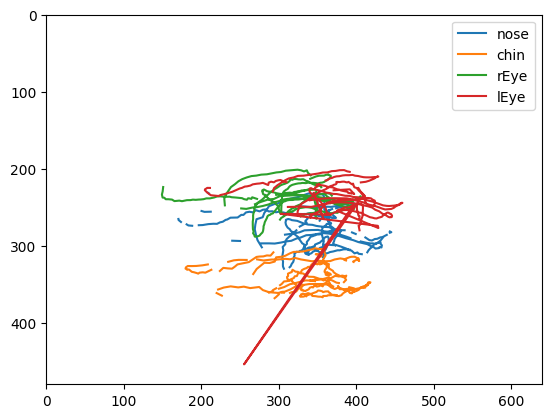

In [10]:
for obj in project.object_list:
    plt.plot(df[f"{obj}_x"],df[f"{obj}_y"],label=obj)
plt.xlim(0,640)
plt.ylim(0,480)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.legend()